In [1]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [2]:
def log_normal(x,mean,sig,theta):
    y = np.exp(-(np.log((x-theta)/mean))**2/(2*sig**2)) / ( (x-theta) * sig*np.sqrt(2*np.pi))
    return(y)

In [3]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def casey_2012(wave,beta,T,wave_0):
    h = 6.63E-34
    K = 1.38E-23
    c = 3E8
    freq = c/(wave*1E-6)
    print(freq)
    vo = c/(wave_0*1E-6)
    
    flux = (1 - np.exp(-(freq/vo)**beta))*(freq)**3 / (np.exp(freq*h/(K*T)) - 1)
    return(flux)

In [5]:
def delhaize_fit(z):
    y = 2.88*(1+z)**-0.19
    return(y)

In [6]:
def gurkan_fit(L250):
    L150 = L250**1.15*10**(-5.05)
    return(L150)

In [7]:
def straight_line(x,params):
    m,c = params
    y = m*x + c
    return(y)

In [8]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [9]:
def donley_agn(i1,i2,i3,i4,c1=0.08,c2=0.15,c3=1.21,c4=0.27):
    '''
    returns a masked column for the sources with True corresponding to AGN selected bby the Donley et al 2012
    selection criteria.
    NOTE: this function can be used to see the affects or changing the criteria slightly
    '''
    x = np.log10(i3/i1)
    y = np.log10(i4/i2)
    
    crit1 = (x>=c1) & (y>=c2) & (y>=(c3*x-c4)) & (y<=(c3*x+c4))
    crit2 = (i2>i1) & (i3>i2) & (i4>i3)
    mask = crit1 & crit2
    
    plt.scatter(x,y,s=1.0,c='blue')
    plt.scatter(x[mask],y[mask],s=1.0,c='red')
    plt.show()
    
    return(mask)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.io import ascii, fits
from astropy.table import Table
from astropy import units as u

import herschelhelp.cutouts_server as ctts

def find_ra_and_dec(colnames):
    '''Finds the ra and dec column names regardless of what case they are in'''
    raname = ''
    decname = ''
    for n,colname in enumerate(colnames):
        if colname.lower() == 'ra':
            raname = colname
        if colname.lower() == 'dec':
            decname = colname
        if (raname != '') & (decname != ''):
            return(raname,decname)
        
def get_pix_length(image,wcs,box_length,ra_cent,dec_cent):
    #returns the number of pixels needed to encompass a box of given boxlength in degrees
    
    pix_centx, pix_centy = wcs.wcs_world2pix(ra_cent,dec_cent,0,ra_dec_order=True)
    pixscale_x, pixscale_y = np.array(wcs.wcs_pix2world(pix_centx,pix_centy,0,ra_dec_order=True)) - np.array(wcs.wcs_pix2world(pix_centx+1,pix_centy+1,0,ra_dec_order=True))

    pix_num_x = box_length/pixscale_x
    pix_num_y = box_length/pixscale_y
    
    return(abs(pix_num_x),abs(pix_num_y))

def cat_plot(ra,dec,wcs,ax,marker='dot',col='red',size=10,colz=False,redshift=None):
    '''
    Given a set of ra and dec will plot points on the given axis using the given wcs.
    The marker, size and colour of the points can be chosen and the points can be coloured
    according to their redshift
    -----------------------------
    Inputs
    ra: list or array of right ascensions
    dec: list or array of declinations
    wcs: the wcs of the axis the points are being displayed on
    ax: the matplotlib axis that the points are being displayed on
    marker: the marker style of the points (default dot/circle)
    col: The colour of the points (default red)
    size: The size of the points
    colz: whether to colour the points according to their redshifts
    redshift list or array of redshifts
    
    Outputs
    colbar: The colour bar corresponding to the redshifts so it can be plotted 
    
    '''
    pixx,pixy = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    if colz==True:
        print('using redshift')
        col = redshift

    colbar = ax.scatter(ra,dec,marker=marker,c=col,s=size,cmap='Spectral',transform=ax.get_transform('world'))
    if colz==True:
        return(colbar)


def image_plot(image,ra,dec,wcs,box_length,fig):
    '''
    create a matplotlib image plot of a cutout of the given image
    --------------------------
    Inputs
    image: 2d array contianing the image data
    ra: right ascension of the center of the image
    dec: declination of the center of the image
    wcs: the wcs of the image
    box_length: give the boxlength in arcseconds
    fig: the figure that the matplotlib axis will be created in
    
    Output
    wcscut: the wcs of the cutout
    ax: the axis containg the cutout image
    '''
    cmap = 'binary'
    origin = 'lower'
    
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    #length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)
    pix_cent_x, pix_cent_y = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    pixscale = np.array(wcs.wcs_pix2world(0,0,0)) - np.array(wcs.wcs_pix2world(1,1,0))
    imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs
    imgcut = imgcut.data

    vmin, vmax = ctts.cutout_scale(imgcut)
    ax = fig.add_subplot(111, projection=wcscut)

    ax.imshow(imgcut, vmax=vmax, vmin=vmin, cmap=cmap, interpolation='nearest', origin=origin)

    return(wcscut,ax)
    

def contour_plot(data,ra,dec,box_length,ax):
    '''
    create a contour plot of the given data on the given axis
    -------------------------
    Inputs
    data: a 2d array of the data that will be used to create the contour plot
    ra: the right ascension of the center of the data
    dec: the declination of the center of the data
    box_length: the length of the cutout in degrees
    ax: a matplotlib axis that the contour plot will be created in
    
    Output
    ax: the axis that now contains the contour plot
    '''
    
    image,wcs = data
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    #length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)

    imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs.celestial
    imgcut = imgcut.data
    vmin, vmax = ctts.cutout_scale(imgcut)
    print('contours are at {}'.format(np.linspace(vmin,vmax,7)))
    
    ax.contour(imgcut,levels=np.linspace(vmin,vmax,7),colors='white',transform=ax.get_transform(wcscut))
    
    return(ax)

def plot_figure(image,cat,wcs,ra_cent,dec_cent,plot_params,contour_data=None):
    '''
    creates a figure containing a cutout of a image with points, from multiple catalogues, 
    overplotted on it which can be coloured according to their redshift. In addition a contour 
    plot of a sperate image can be overplotted
    --------------------
    Input
    image: A 2d array contaiing teh image data
    cat: an astropy table or list of astropy tables which contain the sources that you want 
    overplotted on the image. These catalogues do not need to be cutdown to the image area beforehand
    wcs: the wcs of the image being plotted
    ra_cent: the right ascension of the center of the desired cutout
    dec_cent: the declination of the center of the desired cutout
    plot_params: A dictionary containing the parameters for plotting the catalogues
        marker: a list of matplotlib markers for each catalogue
        col: a list of colors, one for each catalogue
        size: a list of sizes, one size for each catalogue
        box_length: the side legth of the desired cutout in degrees
        use_redshift: boolean for whether colours should be assigned based on the points redshift
    contour_data: default None. If not none should be a list containing [data,wcs] where data is a 2d array 
    containing the data that will be used to onstruct the contour plot and wcs is the wcs of the contour data
        
    '''
    
    #unpack plot_params
    marker,col,size,box_length,use_redshift = plot_params.values()
    
    #plot the cutout of the image and return the axis and the wcs of the cutout
    fig = plt.figure(figsize=(10,10))
    length_x, length_y = get_pix_length(image,wcs,box_length,ra_cent,dec_cent)
    wcsimg,ax = image_plot(image,ra_cent,dec_cent,wcs,box_length,fig)
    
    #create the radio contour plot and superimpose it onot the image cutout
    if contour_data != None:
        ax = contour_plot(contour_data,ra_cent,dec_cent,box_length,ax)
        ax.set_xlim(0,length_y-1)
        ax.set_ylim(0,length_y-1)
    
    #select the sources within the cutout from the catalogue and plot them
    ramax = ra_cent + box_length/2/np.cos(box_length/2)
    ramin = ra_cent - box_length/2/np.cos(box_length/2)

    decmax = dec_cent + box_length/2
    decmin = dec_cent - box_length/2
    #print('ramax = {}\nramin = {}\ndecmax = {}\ndecmin = {}'.format(ramax,ramin,decmax,decmin))
    if type(cat) != list:
        raname,decname = find_ra_and_dec(catalogue.colnames)
        mask = (cat[raname]>ramin) & (cat[raname]<ramax)  &  (cat[decname]>decmin) & (cat[decname]<decmax)
        cat = cat[mask]
        print('plotting {} sources'.format(len(catalogue)))
        if plot_params['use_redshift']==False:
            cat_plot(cat[raname],cat[decname],wcsimg,ax,marker[0],col,size)
        else:
            #the redshift column may need to be changed if your redhsift column isn't called 'redshift'
            colbar = cat_plot(cat[raname],cat[decname],wcsimg,ax,marker[0],col,size,colz=True,redshift=catalogue['redshift'])
            fig.colorbar(colbar)
    else:
        for n,catalogue in enumerate(cat):
            raname,decname = find_ra_and_dec(catalogue.colnames)
            mask = (catalogue[raname]>ramin) & (catalogue[raname]<ramax)  &  (catalogue[decname]>decmin) & (catalogue[decname]<decmax)
            catalogue = catalogue[mask]
            print('plotting {} sources'.format(len(catalogue)))
            if plot_params['use_redshift'][n]==False:
                cat_plot(catalogue[raname],catalogue[decname],wcsimg,ax,marker[n],col[n],size)
            else:
                #the redshift column may need to be changed if your redhsift column isn't called 'redshift'
                colbar = cat_plot(catalogue[raname],catalogue[decname],wcsimg,ax,marker[n],col[n],size,colz=True,redshift=catalogue['redshift'])
                fig.colorbar(colbar)
            
        
    

    plt.show()
    

In [8]:
vla_data = Table.read('data/VLA_3GHz_counterpart_array_20170210_paper_delvecchio_et_al.fits.txt')
vla_data[0]

<Row index=0 masked=True>
ID_VLA3  RA_VLA3   DEC_VLA3  Z_BEST       Z_TYPE      FLUX_INT_3GHz Lradio_10cm Lradio_21cm L_TIR_SF       flag_herschel3        Mstar     SFR_IR   NUV_R   XRAY_AGN MIR_AGN SED_AGN Radio_excess      Class      
 int32   float64   float64  float32      bytes17         float64      float64     float64   float64           bytes25           float64   float64  float64   int32    int32   int32     int32         bytes16     
------- ---------- -------- ------- ----------------- ------------- ----------- ----------- -------- ------------------------- --------- --------- -------- -------- ------- ------- ------------ ----------------
      1 149.647714 2.095465  1.5457 phot                   16147.04   25.839253   25.717876  11.6626 true                      11.224274 45.983324 2.416443        0       0       0            1 MLAGN

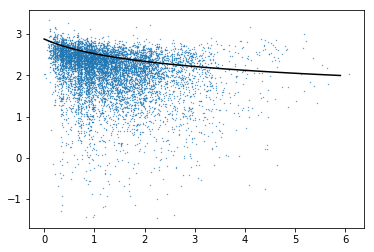

In [17]:
fir_lum_watts = 10**vla_data['L_TIR_SF']*3.8E26
rad_lum_watts = 10**vla_data['Lradio_21cm']
q = np.log10(fir_lum_watts/3.75E12) -np.log10(rad_lum_watts)

x = vla_data['Z_BEST']
plt.scatter(x,q,s=0.1)

x = np.arange(0,6,0.1)
y = delhaize_fit(x)
plt.plot(x,y,c='black')
plt.show()

In [11]:
help_masterlist = Table.read('../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist[0]

<Row index=0>
          help_id            field           ra                dec          hp_idx          ebv          redshift  zspec  f_wfc_u ferr_wfc_u f_ap_wfc_u ferr_ap_wfc_u m_wfc_u merr_wfc_u m_ap_wfc_u merr_ap_wfc_u flag_wfc_u f_megacam_u ferr_megacam_u f_ap_megacam_u ferr_ap_megacam_u m_megacam_u merr_megacam_u m_ap_megacam_u merr_ap_megacam_u flag_megacam_u f_suprime_g ferr_suprime_g f_ap_suprime_g ferr_ap_suprime_g m_suprime_g merr_suprime_g m_ap_suprime_g merr_ap_suprime_g flag_suprime_g f_megacam_g ferr_megacam_g f_ap_megacam_g ferr_ap_megacam_g m_megacam_g merr_megacam_g m_ap_megacam_g merr_ap_megacam_g flag_megacam_g f_gpc1_g ferr_gpc1_g f_ap_gpc1_g ferr_ap_gpc1_g m_gpc1_g merr_gpc1_g m_ap_gpc1_g merr_ap_gpc1_g flag_gpc1_g f_wfc_g ferr_wfc_g f_ap_wfc_g ferr_ap_wfc_g m_wfc_g merr_wfc_g m_ap_wfc_g merr_ap_wfc_g flag_wfc_g f_suprime_r ferr_suprime_r f_ap_suprime_r ferr_ap_suprime_r m_suprime_r merr_suprime_r m_ap_suprime_r merr_ap_suprime_r flag_suprime_r f_gpc1_r ferr_gpc1_r f_ap_gpc1_r ferr_ap_gpc1_r m_gpc1_r merr_gpc1_r m_ap_gpc1_r merr_ap_gpc1_r flag_gpc1_r f_wfc_r ferr_wfc_r f_ap_wfc_r ferr_ap_wfc_r m_wfc_r merr_wfc_r m_ap_wfc_r merr_ap_wfc_r flag_wfc_r f_megacam_r ferr_megacam_r f_ap_megacam_r ferr_ap_megacam_r m_megacam_r merr_megacam_r m_ap_megacam_r merr_ap_megacam_r flag_megacam_r f_gpc1_i ferr_gpc1_i f_ap_gpc1_i ferr_ap_gpc1_i m_gpc1_i merr_gpc1_i m_ap_gpc1_i merr_ap_gpc1_i flag_gpc1_i f_suprime_i ferr_suprime_i f_ap_suprime_i ferr_ap_suprime_i m_suprime_i merr_suprime_i m_ap_suprime_i merr_ap_suprime_i flag_suprime_i f_wfc_i ferr_wfc_i f_ap_wfc_i ferr_ap_wfc_i m_wfc_i merr_wfc_i m_ap_wfc_i merr_ap_wfc_i flag_wfc_i f_gpc1_z ferr_gpc1_z f_ap_gpc1_z ferr_ap_gpc1_z m_gpc1_z merr_gpc1_z m_ap_gpc1_z merr_ap_gpc1_z flag_gpc1_z f_wfc_z ferr_wfc_z f_ap_wfc_z ferr_ap_wfc_z m_wfc_z merr_wfc_z m_ap_wfc_z merr_ap_wfc_z flag_wfc_z f_megacam_z ferr_megacam_z f_ap_megacam_z ferr_ap_megacam_z m_megacam_z merr_megacam_z m_ap_megacam_z merr_ap_megacam_z flag_megacam_z f_suprime_z ferr_suprime_z f_ap_suprime_z ferr_ap_suprime_z m_suprime_z merr_suprime_z m_ap_suprime_z merr_ap_suprime_z flag_suprime_z f_suprime_n921 ferr_suprime_n921 f_ap_suprime_n921 ferr_ap_suprime_n921 m_suprime_n921 merr_suprime_n921 m_ap_suprime_n921 merr_ap_suprime_n921 flag_suprime_n921 f_gpc1_y ferr_gpc1_y f_ap_gpc1_y ferr_ap_gpc1_y m_gpc1_y merr_gpc1_y m_ap_gpc1_y merr_ap_gpc1_y flag_gpc1_y f_suprime_y ferr_suprime_y f_ap_suprime_y ferr_ap_suprime_y m_suprime_y merr_suprime_y m_ap_suprime_y merr_ap_suprime_y flag_suprime_y f_ukidss_j ferr_ukidss_j f_ap_ukidss_j ferr_ap_ukidss_j m_ukidss_j merr_ukidss_j m_ap_ukidss_j merr_ap_ukidss_j flag_ukidss_j f_ukidss_k ferr_ukidss_k f_ap_ukidss_k ferr_ap_ukidss_k m_ukidss_k merr_ukidss_k m_ap_ukidss_k merr_ap_ukidss_k flag_ukidss_k f_irac_i1 ferr_irac_i1 f_ap_irac_i1 ferr_ap_irac_i1 m_irac_i1 merr_irac_i1 m_ap_irac_i1 merr_ap_irac_i1 flag_irac_i1 f_irac_i2 ferr_irac_i2 f_ap_irac_i2 ferr_ap_irac_i2 m_irac_i2 merr_irac_i2 m_ap_irac_i2 merr_ap_irac_i2 flag_irac_i2 f_irac_i3 ferr_irac_i3 f_ap_irac_i3 ferr_ap_irac_i3 m_irac_i3 merr_irac_i3 m_ap_irac_i3 merr_ap_irac_i3 flag_irac_i3 f_irac_i4 ferr_irac_i4 f_ap_irac_i4 ferr_ap_irac_i4 m_irac_i4 merr_irac_i4 m_ap_irac_i4 merr_ap_irac_i4 flag_irac_i4 f_mips_24 ferr_mips_24 flag_mips_24 f_pacs_green ferr_pacs_green flag_pacs_green f_pacs_red ferr_pacs_red flag_pacs_red f_spire_250 ferr_spire_250 flag_spire_250 f_spire_350 ferr_spire_350 flag_spire_350 f_spire_500 ferr_spire_500 flag_spire_500 cigale_mstar cigale_mstar_err cigale_sfr cigale_sfr_err cigale_dustlumin cigale_dustlumin_err cigale_dustlumin_ironly cigale_dustlumin_ironly_err flag_cigale flag_cigale_opt flag_cigale_ir flag_cigale_ironly      stellarity     stellarity_origin flag_cleaned flag_merged flag_gaia flag_optnir_obs flag_optnir_det zspec_qual zspec_association_flag
                                            deg                deg                                                                         

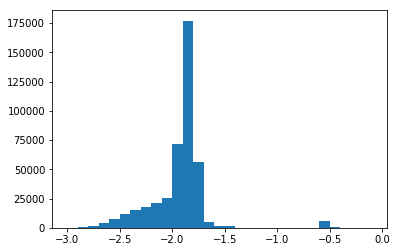

In [12]:
y = np.log10(help_masterlist['ferr_mips_24']) - 3
bins = np.arange(-3,0,0.1)
plt.hist(y,bins=bins)
plt.show()

In [13]:
lofar_data = Table.read('../lofar/deep_fields/ELAIS-N1/data/data_release/lofar_XID+_merged.fits')
lofar_data[0]

<Row index=0 masked=True>
          id                   RA                DEC                 E_RA                E_DEC               Total_flux           E_Total_flux            Peak_flux            E_Peak_flux      S_Code         Maj                   Min                  PA                 E_Maj                  E_Min                 E_PA         DC_Maj  DC_Min  DC_PA  FLAG_WORKFLOW Prefilter  NoID       lr_fin            optRA              optDec      LGZ_Size LGZ_Width  LGZ_PA Assoc Assoc_Qual Art_prob Blend_prob Hostbroken_prob Imagemissing_prob Zoom_prob        Created         Position_from Renamed_from FLAG_OVERLAP_RADIO flag_clean_radio  NUMBER  X_IMAGE  Y_IMAGE     ALPHA_J2000        DELTA_J2000    flag_clean NUMBER_OPTICAL NUMBER_SPITZER FLAG_OVERLAP Separation           help_id                RA_HELP           DEC_HELP          EBV      Z_SPEC CLASS_STAR MegaCam.u.res MegaCam.u.res_err  PS1.g.res   PS1.g.res_err PS1.r.res PS1.r.res_err PS1.i.res PS1.i.res_err   PS1.z.res   PS1.z.res_err PS1.y.res PS1.y.res_err HSC-g_mod.res HSC-g_mod.res_err HSC-r_mod.res HSC-r_mod.res_err HSC-i_mod.res HSC-i_mod.res_err HSC-z_mod.res HSC-z_mod.res_err HSC-Y_mod.res HSC-Y_mod.res_err wHSC-NB921_mod.res wHSC-NB921_mod.res_err UKIDSS.J.res UKIDSS.J.res_err UKIDSS.K.res UKIDSS.K.res_err IRAC.I1.res IRAC.I1.res_err IRAC.I2.res IRAC.I2.res_err ch1_swire_flux ch1_swire_fluxerr ch2_swire_flux ch2_swire_fluxerr IRAC.I3.res IRAC.I3.res_err IRAC.I4.res IRAC.I4.res_err  mips_24  FErr_MIPS_24_u FErr_MIPS_24_l  Bkg_MIPS_24  Sig_conf_MIPS_24 Rhat_MIPS_24 n_eff_MIPS_24 Pval_res_24 flag_mips_24 pacs_green FErr_PACS_100_u FErr_PACS_100_l  pacs_red FErr_PACS_160_u FErr_PACS_160_l  Bkg_PACS_100  Bkg_PACS_160 Sig_conf_PACS_100 Sig_conf_PACS_160 Rhat_PACS_100 Rhat_PACS_160 n_eff_PACS_100 n_eff_PACS_160 Pval_res_100 Pval_res_160 flag_PACS_100 flag_PACS_160 spire_250 FErr_SPIRE_250_u FErr_SPIRE_250_l spire_350 FErr_SPIRE_350_u FErr_SPIRE_350_l spire_500 FErr_SPIRE_500_u FErr_SPIRE_500_l Bkg_SPIRE_250 Bkg_SPIRE_350 Bkg_SPIRE_500 Sig_conf_SPIRE_250 Sig_conf_SPIRE_350 Sig_conf_SPIRE_500 Rhat_SPIRE_250 Rhat_SPIRE_350 Rhat_SPIRE_500 n_eff_SPIRE_250 n_eff_SPIRE_500 n_eff_SPIRE_350 Pval_res_250 Pval_res_350 Pval_res_500 flag_spire_250 flag_spire_350 flag_spire_500  AGN   optAGN  IRAGN  XrayAGN redshift  z1_min  z1_max z1_area z2_median  z2_min  z2_max z2_area nfilt_eazy nfilt_atlas nfilt_ananna chi_r_best chi_r_stellar stellar_type hp_idx_11 hp_depth_cluster     mips_24_err       pacs_green_err     pacs_red_err      spire_250_err     spire_350_err      spire_500_err  
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

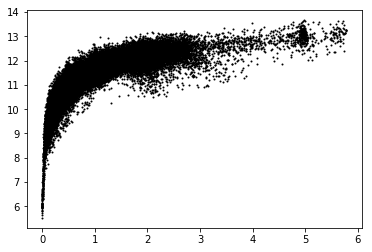

In [14]:
x = help_masterlist['redshift']
y = np.log10(help_masterlist['cigale_dustlumin']/3.8E26)
plt.scatter(x,y,s=1,c='black')
plt.show()

In [15]:
mask = ~np.isnan(help_masterlist['cigale_dustlumin'])
help_ldust = help_masterlist[mask]

ras = lofar_data['optRA']
decs = lofar_data['optDec']
mask = np.isnan(lofar_data['optRA'])
ras[mask] = lofar_data['RA'][mask]
decs[mask] = lofar_data['DEC'][mask]
lofar_coords = SkyCoord(ras,decs,unit='deg')
moc = catalog_to_moc(lofar_coords,15,12)

moc_mask = inMoc(help_ldust['ra'],help_ldust['dec'],moc)
help_ldust = help_ldust[moc_mask]

In [16]:
help_coords = SkyCoord(help_ldust['ra'],help_ldust['dec'],unit='deg')
ras = lofar_data['optRA']
decs = lofar_data['optDec']
mask = np.isnan(lofar_data['optRA'])
ras[mask] = lofar_data['RA'][mask]
decs[mask] = lofar_data['DEC'][mask]
lofar_coords = SkyCoord(ras,decs,unit='deg')

idx_help,d2d,_ = match_coordinates_sky(lofar_coords,help_coords)
#lofar_coords.match_to_catalog_sky(help_coords)
#idx_help,idx_lofar,d2d = lofar_coords.match_to_catalog_sky(help_coords)

In [17]:
tmp = np.unique(idx_help)
idx_help_not = [i for i in range(len(help_coords)) if i not in tmp]

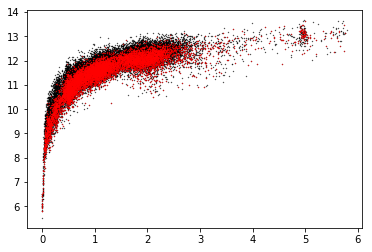

In [18]:
x = help_ldust['redshift']
y = np.log10(help_ldust['cigale_dustlumin']/3.8E26)
plt.scatter(x,y,s=0.1,c='black')

x = help_ldust['redshift'][idx_help_not]
y = np.log10(help_ldust['cigale_dustlumin'][idx_help_not]/3.8E26)
plt.scatter(x,y,s=0.1,c='red')
plt.show()

In [21]:
help_ldust[idx_help_not][mask]

<Table length=23>
          help_id            field   ... zspec_qual zspec_association_flag
                                     ...                                  
         bytes1728          bytes18  ...   int64             bool         
--------------------------- -------- ... ---------- ----------------------
HELP_J160241.073+545254.312 ELAIS-N1 ...        -99                  False
HELP_J160447.907+543729.917 ELAIS-N1 ...        -99                  False
HELP_J160515.899+542637.987 ELAIS-N1 ...        -99                  False
HELP_J160609.117+551023.678 ELAIS-N1 ...        -99                  False
HELP_J160624.377+555059.582 ELAIS-N1 ...        -99                  False
HELP_J160732.066+542223.048 ELAIS-N1 ...          4                  False
HELP_J160804.481+535000.115 ELAIS-N1 ...        -99                  False
HELP_J160904.423+541420.207 ELAIS-N1 ...        -99                  False
HELP_J160906.630+540329.764 ELAIS-N1 ...        -99                  False
                        ...      ... ...        ...                    ...
HELP_J161453.458+550952.035 ELAIS-N1 ...        -99                  False
HELP_J161558.669+533402.107 ELAIS-N1 ...        -99                  False
HELP_J161704.184+542414.583 ELAIS-N1 ...        -99                  False
HELP_J161707.123+553416.845 ELAIS-N1 ...        -99                  False
HELP_J161740.625+545912.310 ELAIS-N1 ...        -99                  False
HELP_J161857.829+545110.693 ELAIS-N1 ...        -99                  False
HELP_J161902.895+551144.493 ELAIS-N1 ...        -99                  False
HELP_J161925.936+554048.457 ELAIS-N1 ...        -99                  False
HELP_J162045.022+544755.753 ELAIS-N1 ...        -99                  False
HELP_J162045.543+544131.519 ELAIS-N1 ...        -99                  False

In [19]:
mask = (np.log10(help_ldust[idx_help_not]['cigale_dustlumin']/3.8E26)>12) & (help_ldust[idx_help_not]['redshift']>1) & (help_ldust[idx_help_not]['redshift']<1.1)
ras = help_ldust[idx_help_not]['ra'][mask]
decs = help_ldust[idx_help_not]['dec'][mask]

ra is 240.67113575405702 and dec is 54.881753323499304
dust luminosity is 1312424532557.3186 solar_luminosities at redshift 1.0984
predicted radio flux, using q=2.7 is: 0.42571064135263675mJy
contours are at [-5.64239852e-05 -1.95486074e-05  1.73267704e-05  5.42021483e-05
  9.10775261e-05  1.27952904e-04  1.64828282e-04]
plotting 1 sources
plotting 3 sources


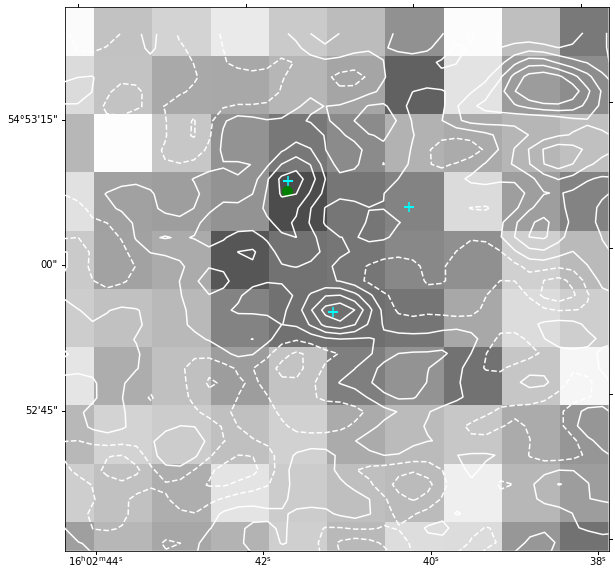

ra is 241.199614200057 and dec is 54.6249770004993
dust luminosity is 1095151167518.55 solar_luminosities at redshift 1.0071
predicted radio flux, using q=2.7 is: 0.4407102944630357mJy
contours are at [-5.90108123e-05 -2.31016539e-05  1.28075045e-05  4.87166630e-05
  8.46258214e-05  1.20534980e-04  1.56444138e-04]
plotting 2 sources
plotting 5 sources


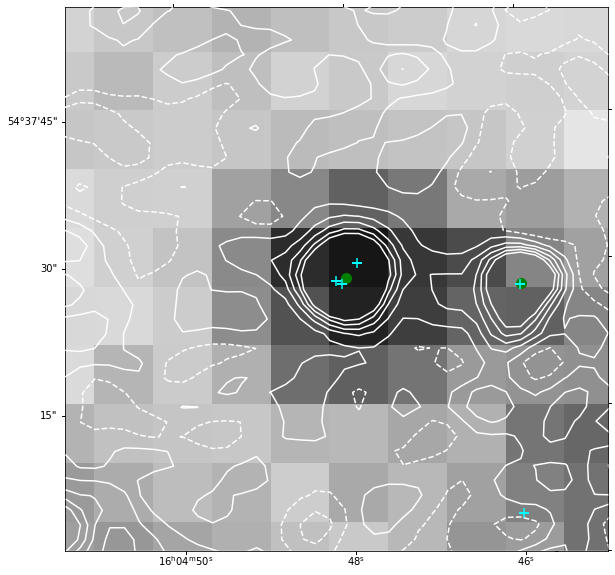

ra is 241.316247229057 and dec is 54.4438853254993
dust luminosity is 1055973289053.5828 solar_luminosities at redshift 1.0658
predicted radio flux, using q=2.7 is: 0.36915734526922556mJy
contours are at [-5.22049382e-05 -1.93593488e-05  1.34862407e-05  4.63318301e-05
  7.91774195e-05  1.12023009e-04  1.44868598e-04]
plotting 1 sources
plotting 3 sources


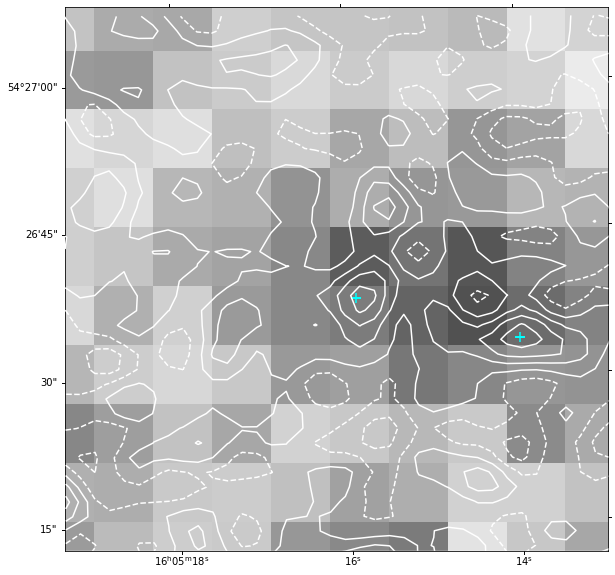

ra is 241.53798716205702 and dec is 55.1732440094993
dust luminosity is 1242010266191.896 solar_luminosities at redshift 1.0463
predicted radio flux, using q=2.7 is: 0.4545798433714106mJy
contours are at [-6.05330005e-05 -2.57084131e-05  9.11617423e-06  4.39407616e-05
  7.87653490e-05  1.13589936e-04  1.48414524e-04]
plotting 3 sources
plotting 4 sources


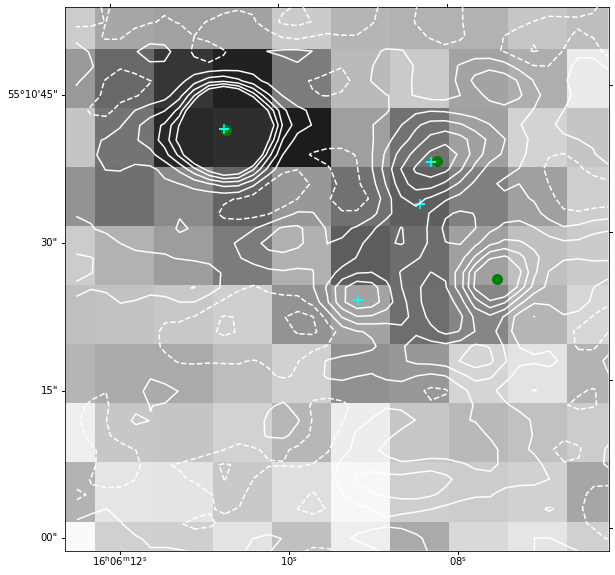

ra is 241.60157171505702 and dec is 55.8498840154993
dust luminosity is 1047410162092.201 solar_luminosities at redshift 1.0676
predicted radio flux, using q=2.7 is: 0.36463156749891934mJy
contours are at [-6.09282591e-05 -2.50353860e-05  1.08574871e-05  4.67503602e-05
  8.26432333e-05  1.18536106e-04  1.54428980e-04]
plotting 1 sources
plotting 5 sources


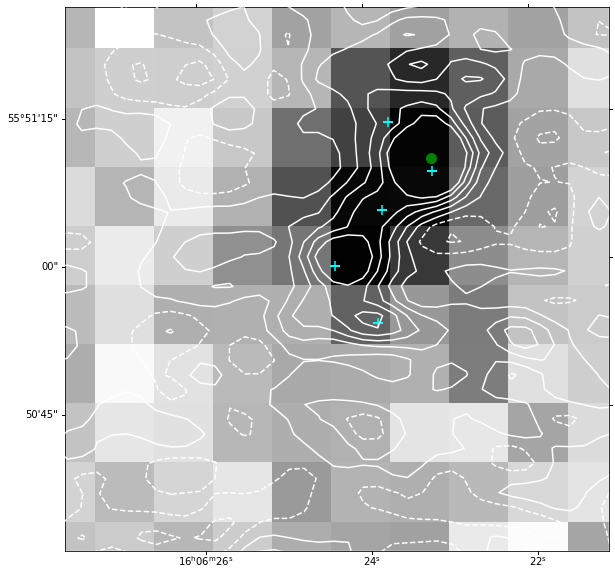

ra is 241.883607749057 and dec is 54.3730689774993
dust luminosity is 1911913553783.0913 solar_luminosities at redshift 1.0095
predicted radio flux, using q=2.7 is: 0.7648567856540273mJy
contours are at [-6.39707800e-05 -1.64049936e-05  3.11607929e-05  7.87265793e-05
  1.26292366e-04  1.73858152e-04  2.21423938e-04]
plotting 2 sources
plotting 5 sources


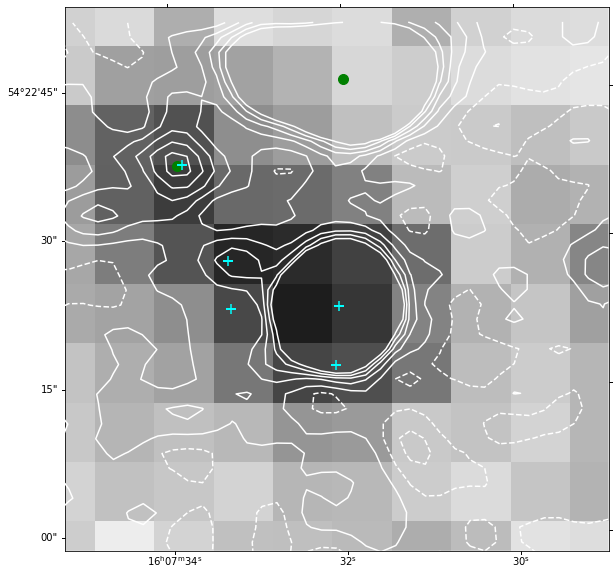

ra is 242.018671286057 and dec is 53.8333651984993
dust luminosity is 1029258234320.8525 solar_luminosities at redshift 1.0909
predicted radio flux, using q=2.7 is: 0.33959398101176275mJy
contours are at [-6.22747148e-05 -2.48441704e-05  1.25863739e-05  5.00169183e-05
  8.74474627e-05  1.24878007e-04  1.62308551e-04]
plotting 2 sources
plotting 4 sources


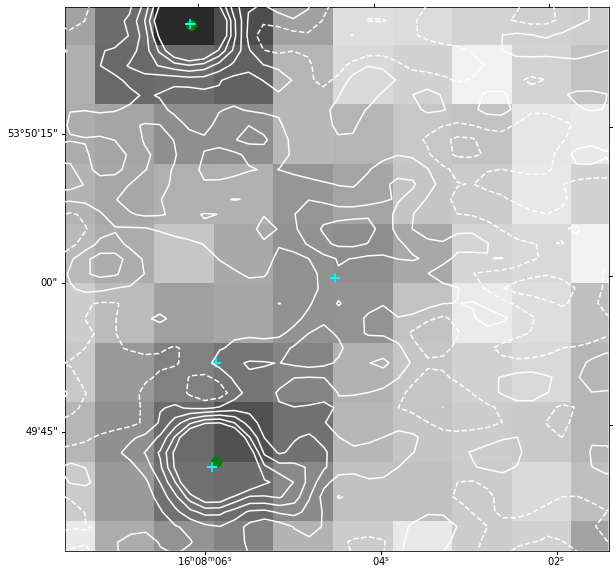

ra is 242.268430793057 and dec is 54.2389464764993
dust luminosity is 1088866018485.2192 solar_luminosities at redshift 1.0315
predicted radio flux, using q=2.7 is: 0.41288599617019806mJy
contours are at [-4.71417488e-05 -1.67272413e-05  1.36872662e-05  4.41017737e-05
  7.45162812e-05  1.04930789e-04  1.35345296e-04]
plotting 1 sources
plotting 3 sources


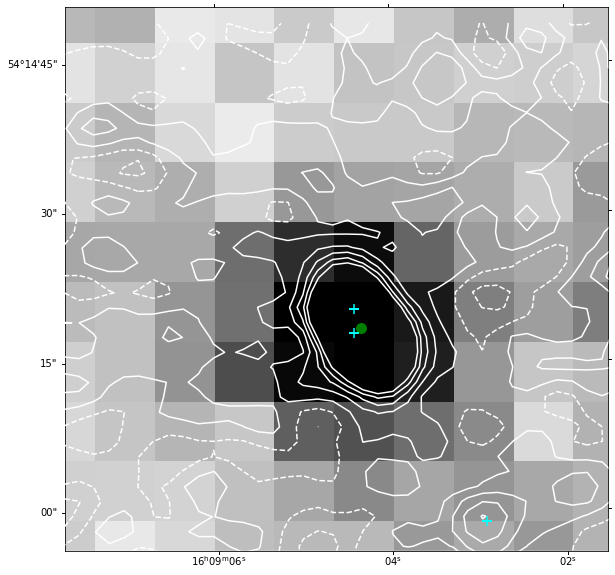

ra is 242.27762687049727 and dec is 54.058267895246956
dust luminosity is 1277038801775.722 solar_luminosities at redshift 1.0644
predicted radio flux, using q=2.7 is: 0.4479001382088517mJy
contours are at [-4.70294995e-05 -1.53170192e-05  1.63954610e-05  4.81079412e-05
  7.98204215e-05  1.11532902e-04  1.43245382e-04]
plotting 1 sources
plotting 3 sources


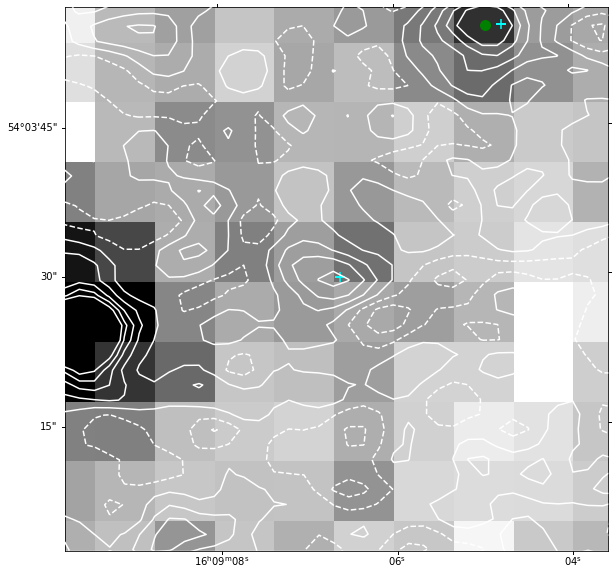

ra is 242.528298297057 and dec is 56.4157721604993
dust luminosity is 1034999889339.7261 solar_luminosities at redshift 1.0785
predicted radio flux, using q=2.7 is: 0.35132956042869445mJy
contours are at [-5.99441133e-05 -1.12717883e-05  3.74005367e-05  8.60728617e-05
  1.34745187e-04  1.83417512e-04  2.32089837e-04]
plotting 2 sources
plotting 3 sources


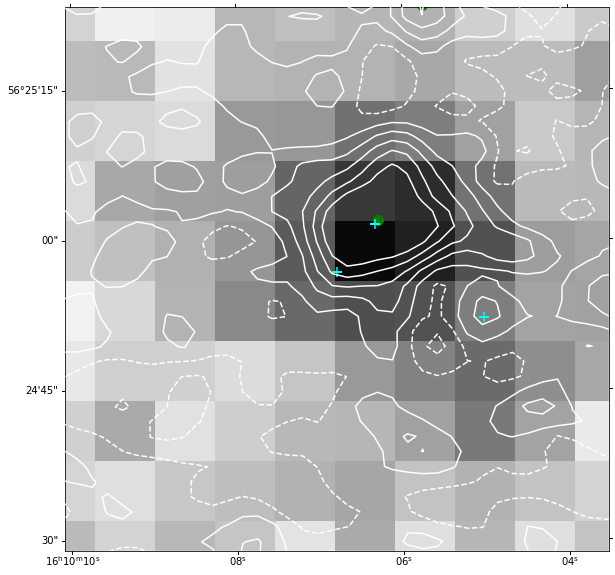

ra is 242.55212708647923 and dec is 55.75133670787837
dust luminosity is 1002639410316.6813 solar_luminosities at redshift 1.049
predicted radio flux, using q=2.7 is: 0.3646270414264467mJy
contours are at [-5.48874169e-05 -2.39104151e-05  7.06658671e-06  3.80435885e-05
  6.90205903e-05  9.99975921e-05  1.30974594e-04]
plotting 2 sources
plotting 3 sources


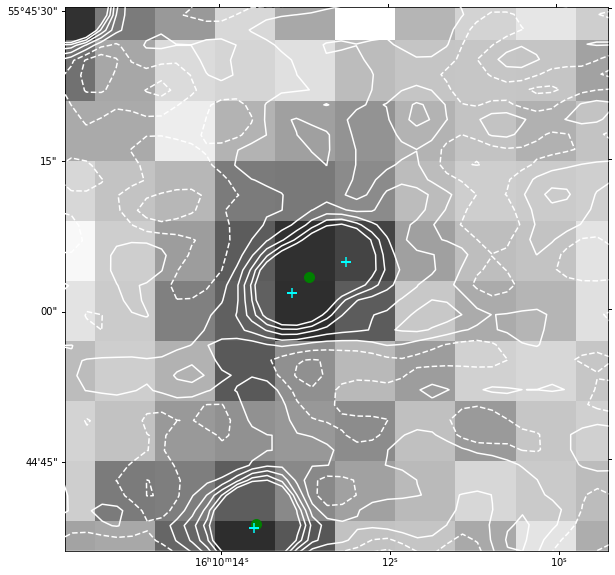

ra is 242.836812067057 and dec is 54.6110585554993
dust luminosity is 1182387912262.497 solar_luminosities at redshift 1.019
predicted radio flux, using q=2.7 is: 0.4621347179663661mJy
contours are at [-4.63569230e-05 -2.17186596e-05  2.91960378e-06  2.75578672e-05
  5.21961306e-05  7.68343939e-05  1.01472657e-04]
plotting 1 sources
plotting 2 sources


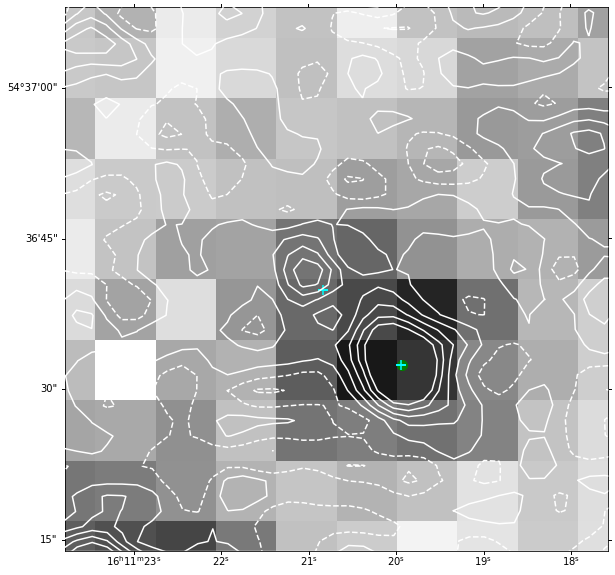

ra is 243.62401668605702 and dec is 56.0772288804993
dust luminosity is 1666323978438.8289 solar_luminosities at redshift 1.0651
predicted radio flux, using q=2.7 is: 0.583481451954336mJy
contours are at [-9.58830582e-05 -1.29383297e-05  7.00063989e-05  1.52951127e-04
  2.35895856e-04  3.18840585e-04  4.01785313e-04]
plotting 2 sources
plotting 2 sources


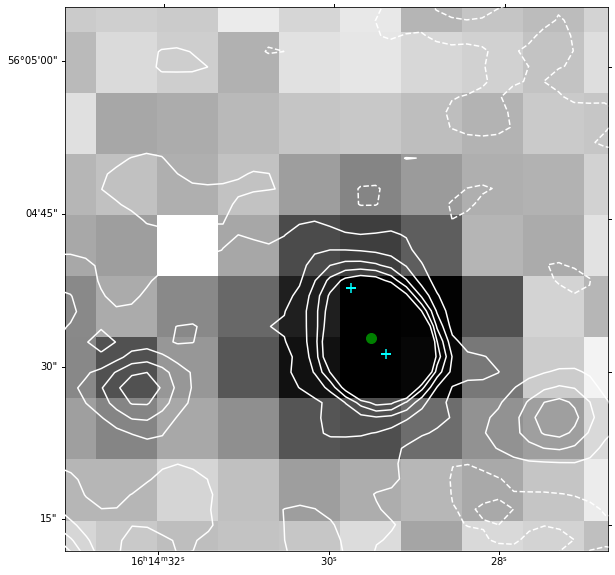

ra is 243.722742392057 and dec is 55.1644540674993
dust luminosity is 1232986134997.2434 solar_luminosities at redshift 1.0869
predicted radio flux, using q=2.7 is: 0.41054311691883133mJy
contours are at [-5.45104848e-05 -1.93703413e-05  1.57698021e-05  5.09099456e-05
  8.60500890e-05  1.21190232e-04  1.56330376e-04]
plotting 1 sources
plotting 3 sources


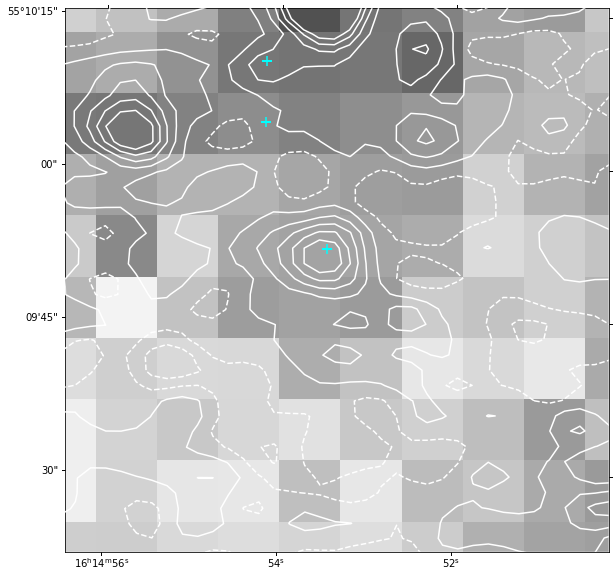

ra is 243.99445328605702 and dec is 53.5672520084993
dust luminosity is 1001153759747.979 solar_luminosities at redshift 1.018
predicted radio flux, using q=2.7 is: 0.39225501824247827mJy
contours are at [-5.67122536e-05 -1.93171870e-05  1.80778796e-05  5.54729461e-05
  9.28680127e-05  1.30263079e-04  1.67658146e-04]
plotting 1 sources
plotting 1 sources


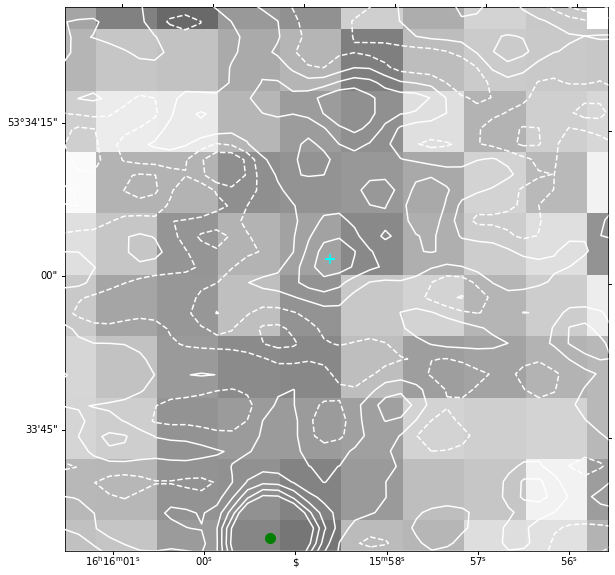

ra is 244.26743480922428 and dec is 54.40405071130881
dust luminosity is 1018362437477.6906 solar_luminosities at redshift 1.0657
predicted radio flux, using q=2.7 is: 0.35609199840084205mJy
contours are at [-4.78897793e-05 -1.86764105e-05  1.05369583e-05  3.97503271e-05
  6.89636959e-05  9.81770647e-05  1.27390434e-04]
plotting 2 sources
plotting 2 sources


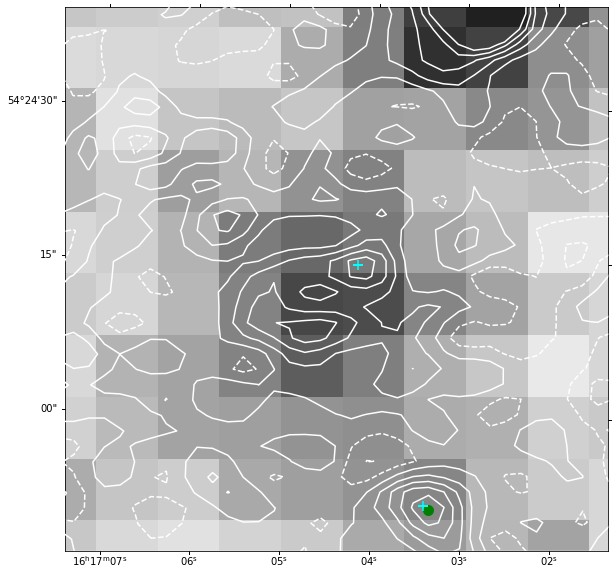

ra is 244.279677709057 and dec is 55.571345965499304
dust luminosity is 1118860923883.03 solar_luminosities at redshift 1.0815
predicted radio flux, using q=2.7 is: 0.37718328194680273mJy
contours are at [-6.44927088e-05 -2.95719261e-05  5.34885654e-06  4.02696392e-05
  7.51904219e-05  1.10111205e-04  1.45031987e-04]
plotting 0 sources
plotting 3 sources


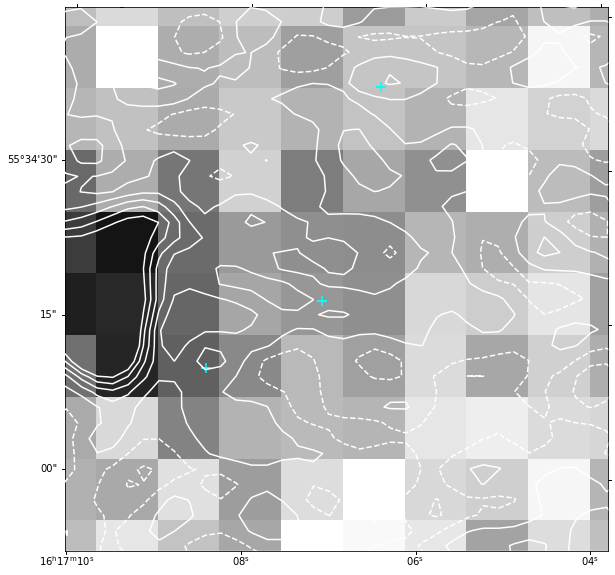

ra is 244.419272905057 and dec is 54.9867527704993
dust luminosity is 1706342904870.8237 solar_luminosities at redshift 1.0638
predicted radio flux, using q=2.7 is: 0.5993105445083433mJy
contours are at [-6.01226973e-05 -2.46648991e-05  1.07928990e-05  4.62506971e-05
  8.17084952e-05  1.17166293e-04  1.52624091e-04]
plotting 3 sources
plotting 5 sources


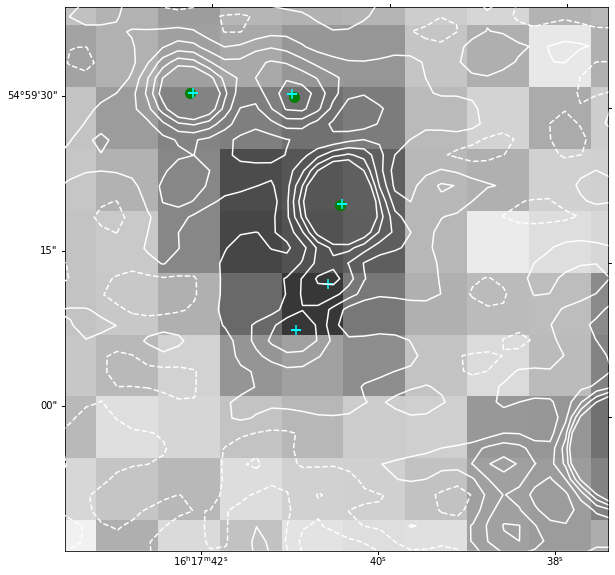

ra is 244.7409528031757 and dec is 54.85297018904767
dust luminosity is 1061565493044.9359 solar_luminosities at redshift 1.0139
predicted radio flux, using q=2.7 is: 0.42011447231059806mJy
contours are at [-6.57379711e-05 -2.60099939e-05  1.37179834e-05  5.34459607e-05
  9.31739380e-05  1.32901915e-04  1.72629892e-04]
plotting 0 sources
plotting 2 sources


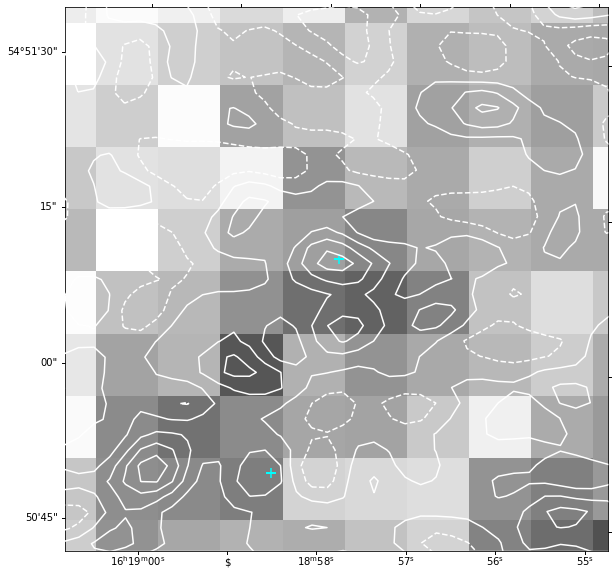

ra is 244.762061631057 and dec is 55.1956926024993
dust luminosity is 1191497815528.0784 solar_luminosities at redshift 1.0821
predicted radio flux, using q=2.7 is: 0.40111689841718473mJy
contours are at [-4.65651243e-05 -1.48020797e-05  1.69609649e-05  4.87240095e-05
  8.04870541e-05  1.12250099e-04  1.44013143e-04]
plotting 4 sources
plotting 4 sources


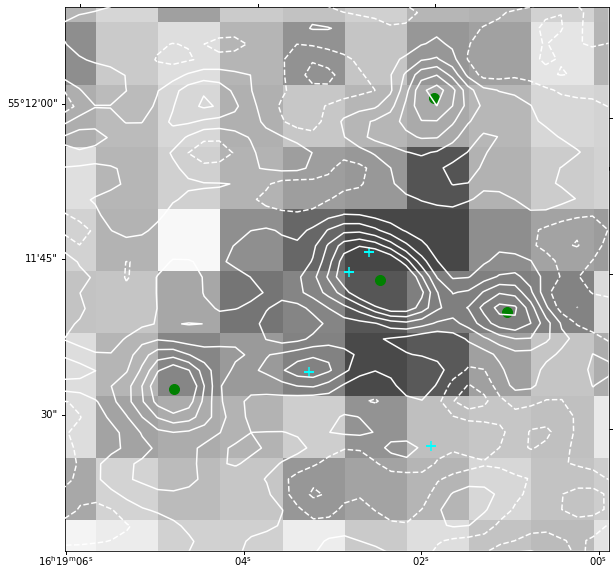

ra is 244.85806576405702 and dec is 55.680127080499304
dust luminosity is 1174472942623.6072 solar_luminosities at redshift 1.0146
predicted radio flux, using q=2.7 is: 0.46400153800553257mJy
contours are at [-5.51337753e-05 -2.13463975e-05  1.24409802e-05  4.62283579e-05
  8.00157357e-05  1.13803113e-04  1.47590491e-04]
plotting 1 sources
plotting 2 sources


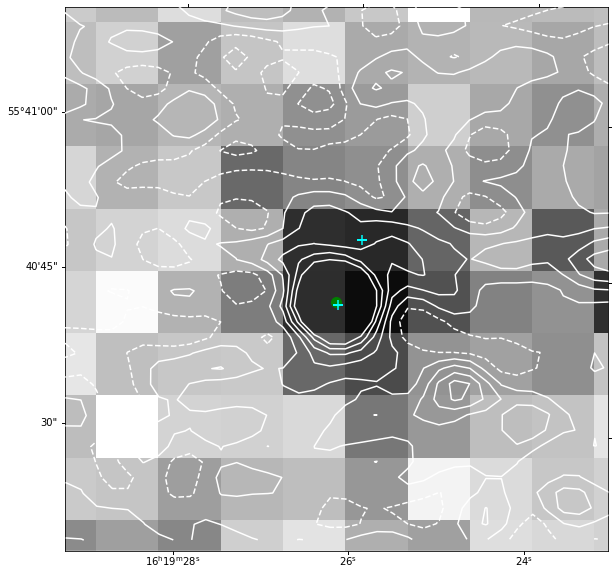

ra is 245.18759163578878 and dec is 54.79882038259069
dust luminosity is 1205772759868.989 solar_luminosities at redshift 1.049
predicted radio flux, using q=2.7 is: 0.4384999727117916mJy
contours are at [-6.34697994e-05 -2.97466536e-05  3.97649220e-06  3.76996380e-05
  7.14227838e-05  1.05145930e-04  1.38869075e-04]
plotting 1 sources
plotting 3 sources


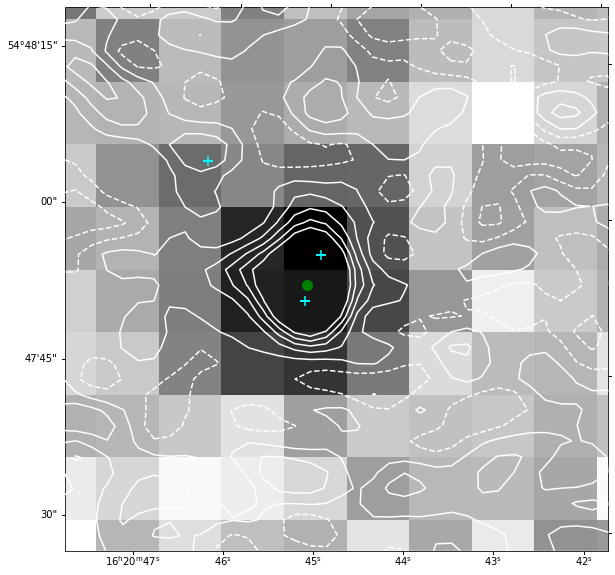

ra is 245.18976055105702 and dec is 54.6920887324993
dust luminosity is 1100392156884.2244 solar_luminosities at redshift 1.0142
predicted radio flux, using q=2.7 is: 0.43516025807523867mJy
contours are at [-5.97002013e-05 -2.63088402e-05  7.08252082e-06  4.04738819e-05
  7.38652429e-05  1.07256604e-04  1.40647965e-04]
plotting 1 sources
plotting 3 sources


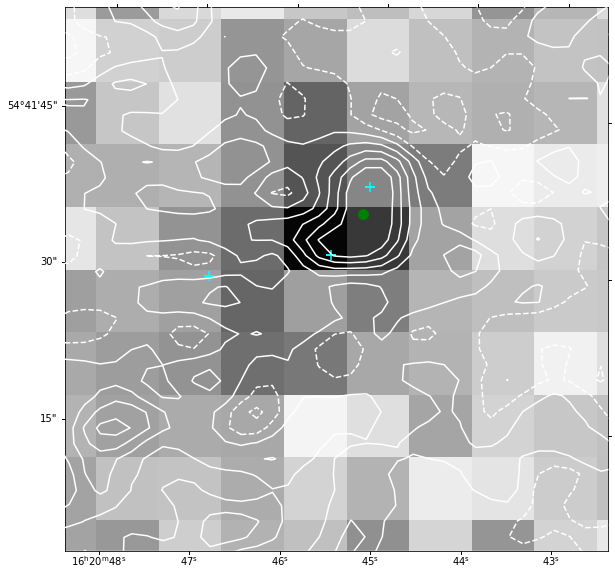

In [22]:
imfolder='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

fname = '../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}
z = help_ldust[idx_help_not][mask]['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad_pred = 10**(np.log10(help_ldust[idx_help_not][mask]['cigale_dustlumin']/3.75E12) - 1.66)
f_rad_pred = lum_rad_pred/(4*np.pi*dist**2)/1E-29
for n in range(len(ras)):
    print('ra is {} and dec is {}'.format(ras[n],decs[n]))
    print('dust luminosity is {} solar_luminosities at redshift {}'.format(help_ldust[idx_help_not][mask][n]['cigale_dustlumin']/3.8E26,help_ldust[idx_help_not][mask][n]['redshift']))
    print('predicted radio flux, using q=2.7 is: {}mJy'.format(f_rad_pred[n]))
    plot_figure(im250,[lofar_data,help_ldust],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [8]:
cigale = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/data/input/out/results.fits')
cigale[0]

<Row index=0>
          id           bayes.stellar.m_star bayes.stellar.m_star_err bayes.sfh.sfr10Myrs bayes.sfh.sfr10Myrs_err bayes.dust.luminosity  bayes.dust.luminosity_err    bayes.dust.mass    bayes.dust.mass_err   bayes.dust.qpah  bayes.dust.qpah_err  bayes.dust.umin  bayes.dust.umin_err  bayes.agn.fracAGN   bayes.agn.fracAGN_err bayes.attenuation.Av_BC bayes.attenuation.Av_BC_err bayes.attenuation.bessell_b bayes.attenuation.bessell_b_err bayes.attenuation.galex_fuv bayes.attenuation.galex_fuv_err bayes.attenuation.slope_BC bayes.attenuation.slope_BC_err bayes.attenuation.BC_to_ISM_factor bayes.attenuation.BC_to_ISM_factor_err bayes.attenuation.slope_ISM bayes.attenuation.slope_ISM_err bayes.sfh.tau_main bayes.sfh.tau_main_err   bayes.sfh.age    bayes.sfh.age_err  bayes.sfh.burst_age bayes.sfh.burst_age_err   bayes.sfh.f_burst   bayes.sfh.f_burst_err  best.chi_square  best.reduced_chi_square best.agn.agn_luminosity best.agn.beta best.agn.fracAGN best.agn.gamma best.agn.luminosity best.agn.opening_angle best.agn.psy best.agn.r_ratio best.agn.scatt_luminosity best.agn.tau best.agn.therm_luminosity best.attenuation.Av_BC best.attenuation.BC_to_ISM_factor best.attenuation.bessell_b best.attenuation.galex_fuv best.attenuation.slope_BC best.attenuation.slope_ISM best.attenuation.stellar.old best.attenuation.stellar.young best.dust.alpha best.dust.gamma  best.dust.luminosity      best.dust.mass     best.dust.qpah best.dust.umin best.lyc_absorption_f_dust best.lyc_absorption_f_esc best.sfh.age best.sfh.burst_age best.sfh.f_burst best.sfh.integrated    best.sfh.sfr   best.sfh.sfr100Myrs best.sfh.sfr10Myrs best.sfh.tau_burst best.sfh.tau_main best.stellar.age_m_star best.stellar.imf  best.stellar.lum_ly   best.stellar.lum_ly_old best.stellar.lum_ly_young best.stellar.m_gas best.stellar.m_gas_old best.stellar.m_gas_young best.stellar.m_star best.stellar.m_star_old best.stellar.m_star_young best.stellar.metallicity   best.stellar.n_ly   best.stellar.n_ly_old best.stellar.n_ly_young best.stellar.old_young_separation_age best.universe.age best.universe.luminosity_distance best.universe.redshift  best.MegaCam.u.res     best.PS1.g.res       best.PS1.r.res       best.PS1.i.res       best.PS1.z.res      best.PS1.y.res    best.HSC-g_mod.res   best.HSC-r_mod.res   best.HSC-i_mod.res   best.HSC-z_mod.res  best.HSC-Y_mod.res best.wHSC-NB921_mod.res best.UKIDSS.J.res   best.UKIDSS.K.res    best.IRAC.I1.res    best.IRAC.I2.res     best.IRAC.I3.res    best.IRAC.I4.res      best.mips_24     best.pacs_green    best.pacs_red      best.spire_250    best.spire_350   best.spire_500  
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [9]:
lofar_cigale = join(lofar_data,cigale,keys='id',join_type='inner')
lofar_cigale[0]

<Row index=0 masked=True>
          id                   RA                DEC                 E_RA                 E_DEC               Total_flux           E_Total_flux           Peak_flux             E_Peak_flux       S_Code         Maj                   Min                 PA                E_Maj                  E_Min                E_PA                DC_Maj                DC_Min             DC_PA       FLAG_WORKFLOW Prefilter  NoID       lr_fin             optRA             optDec      LGZ_Size LGZ_Width  LGZ_PA Assoc Assoc_Qual Art_prob Blend_prob Hostbroken_prob Imagemissing_prob Zoom_prob        Created         Position_from Renamed_from FLAG_OVERLAP_RADIO flag_clean_radio NUMBER X_IMAGE   Y_IMAGE     ALPHA_J2000       DELTA_J2000    flag_clean NUMBER_OPTICAL NUMBER_SPITZER FLAG_OVERLAP Separation           help_id               RA_HELP          DEC_HELP         EBV      Z_SPEC  CLASS_STAR MegaCam.u.res MegaCam.u.res_err  PS1.g.res   PS1.g.res_err  PS1.r.res  PS1.r.res_err  PS1.i.res  PS1.i.res_err  PS1.z.res  PS1.z.res_err  PS1.y.res  PS1.y.res_err HSC-g_mod.res HSC-g_mod.res_err HSC-r_mod.res HSC-r_mod.res_err HSC-i_mod.res HSC-i_mod.res_err HSC-z_mod.res HSC-z_mod.res_err HSC-Y_mod.res HSC-Y_mod.res_err wHSC-NB921_mod.res wHSC-NB921_mod.res_err UKIDSS.J.res UKIDSS.J.res_err UKIDSS.K.res UKIDSS.K.res_err IRAC.I1.res IRAC.I1.res_err IRAC.I2.res IRAC.I2.res_err ch1_swire_flux ch1_swire_fluxerr ch2_swire_flux ch2_swire_fluxerr IRAC.I3.res IRAC.I3.res_err IRAC.I4.res IRAC.I4.res_err  mips_24  FErr_MIPS_24_u FErr_MIPS_24_l Bkg_MIPS_24  Sig_conf_MIPS_24 Rhat_MIPS_24 n_eff_MIPS_24 Pval_res_24 flag_mips_24 pacs_green FErr_PACS_100_u FErr_PACS_100_l  pacs_red FErr_PACS_160_u FErr_PACS_160_l Bkg_PACS_100  Bkg_PACS_160 Sig_conf_PACS_100 Sig_conf_PACS_160 Rhat_PACS_100 Rhat_PACS_160 n_eff_PACS_100 n_eff_PACS_160 Pval_res_100 Pval_res_160 flag_PACS_100 flag_PACS_160 spire_250 FErr_SPIRE_250_u FErr_SPIRE_250_l spire_350 FErr_SPIRE_350_u FErr_SPIRE_350_l spire_500 FErr_SPIRE_500_u FErr_SPIRE_500_l Bkg_SPIRE_250 Bkg_SPIRE_350 Bkg_SPIRE_500 Sig_conf_SPIRE_250 Sig_conf_SPIRE_350 Sig_conf_SPIRE_500 Rhat_SPIRE_250 Rhat_SPIRE_350 Rhat_SPIRE_500 n_eff_SPIRE_250 n_eff_SPIRE_500 n_eff_SPIRE_350 Pval_res_250 Pval_res_350 Pval_res_500 flag_spire_250 flag_spire_350 flag_spire_500  AGN   optAGN  IRAGN  XrayAGN redshift  z1_min  z1_max z1_area z2_median  z2_min  z2_max z2_area nfilt_eazy nfilt_atlas nfilt_ananna chi_r_best chi_r_stellar stellar_type hp_idx_11 hp_depth_cluster     mips_24_err       pacs_green_err      pacs_red_err   spire_250_err spire_350_err   spire_500_err    bayes.stellar.m_star bayes.stellar.m_star_err bayes.sfh.sfr10Myrs bayes.sfh.sfr10Myrs_err bayes.dust.luminosity  bayes.dust.luminosity_err    bayes.dust.mass    bayes.dust.mass_err   bayes.dust.qpah  bayes.dust.qpah_err  bayes.dust.umin  bayes.dust.umin_err  bayes.agn.fracAGN   bayes.agn.fracAGN_err bayes.attenuation.Av_BC bayes.attenuation.Av_BC_err bayes.attenuation.bessell_b bayes.attenuation.bessell_b_err bayes.attenuation.galex_fuv bayes.attenuation.galex_fuv_err bayes.attenuation.slope_BC bayes.attenuation.slope_BC_err bayes.attenuation.BC_to_ISM_factor bayes.attenuation.BC_to_ISM_factor_err bayes.attenuation.slope_ISM bayes.attenuation.slope_ISM_err bayes.sfh.tau_main bayes.sfh.tau_main_err   bayes.sfh.age    bayes.sfh.age_err  bayes.sfh.burst_age bayes.sfh.burst_age_err   bayes.sfh.f_burst   bayes.sfh.f_burst_err  best.chi_square  best.reduced_chi_square best.agn.agn_luminosity best.agn.beta best.agn.fracAGN best.agn.gamma best.agn.luminosity best.agn.opening_angle best.agn.psy best.agn.r_ratio best.agn.scatt_luminosity best.agn.tau best.agn.therm_luminosity best.attenuation.Av_BC best.attenuation.BC_to_ISM_factor best.attenuation.bessell_b best.attenuation.galex_fuv best.attenuation.slope_BC best.attenuation.slope_ISM best.attenuation.stellar.old best.attenuation.stellar.young best.dust.alpha best.dust.gamma  best.dust.luminosity      best.dust.mass     best.dus

In [10]:
mask = ~np.isnan(lofar_cigale['spire_250'])
z = lofar_cigale['redshift'][mask]
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_250 = np.log10(lofar_cigale['spire_250'][mask]*1E-3 * 1E-26 * 4*np.pi*dist**2)
lum_250_lim = np.log10(5*1E-3*1E-26  *4*np.pi*dist**2)
lum_rad = np.log10(lofar_cigale['Total_flux'][mask]*4*np.pi*dist**2 * 1E-26)
flag_250 = lofar_cigale['flag_spire_250'][mask]

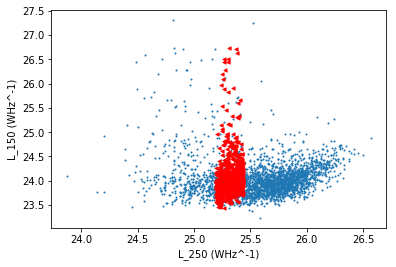

In [11]:
y = lum_rad
x = lum_250
plt.scatter(x,y,s=1)

x = lum_250_lim[flag_250]
y = lum_rad[flag_250]

plt.scatter(x,y,s=10,c='red',marker='<')
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


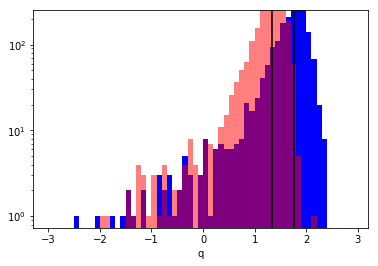

In [140]:
q = lum_250[~flag_250] - lum_rad[~flag_250]
q_lim = lum_250_lim - lum_rad
bins = np.arange(-3,3,0.1)
plt.hist(q,bins=bins,log=True,color='blue')
plt.hist(q_lim,bins=bins,log=True,color='red',alpha=0.5)

plt.vlines(np.median(q),0,500)
plt.vlines(np.median(q_lim),0,500)
plt.xlabel('q')
plt.ylim(0,250)
plt.show()

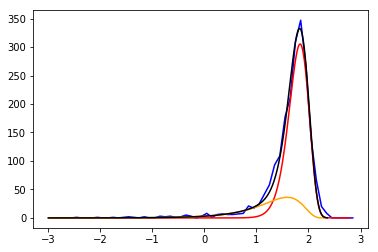

In [169]:
q_plot,_ = np.histogram(q,bins=bins)
x = get_center(bins)
y = q_plot
plt.plot(x,y,c='blue')

x = np.arange(-3,3,0.01)
y1 = log_normal(x,1,0.2,-2.8)*150
plt.plot(0-x,y1,c='red')

x = np.arange(-3,3,0.01)
y2 = log_normal(x,1,0.5,-2.37)*40
plt.plot(0-x,y2,c='orange')

y = y1+y2
plt.plot(0-x,y,c='black')

## Compare Ldust and L250to see how to best relate the selection in f250 to the Ldust plane

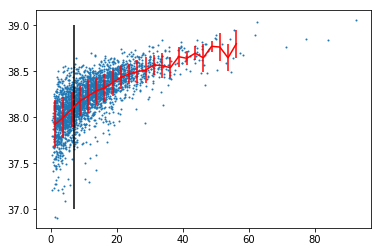

In [186]:
f250 = lofar_cigale['spire_250']
ldust = np.log10(lofar_cigale['bayes.dust.luminosity'])
plt.scatter(f250,ldust,s=1)

bins = np.arange(0,60,2.5)
x = get_center(bins)
mask = ~np.isnan(ldust)
stds,_,_ = binned_statistic(f250[mask],ldust[mask],'std',bins=bins)
means,_,_ = binned_statistic(f250[mask],ldust[mask],'mean',bins=bins)

plt.errorbar(x,means,yerr=stds,c='red')
plt.vlines(7,37,39)

plt.show()

[3.00000000e+14 2.72727273e+14 2.50000000e+14 ... 3.00090027e+11
 3.00060012e+11 3.00030003e+11]


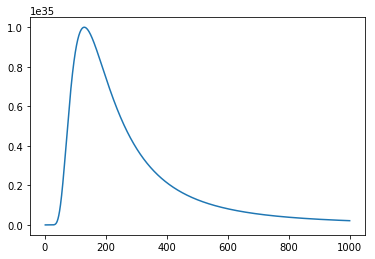

In [206]:
wave = np.arange(1,1000,0.1)
redshift = 1
wave_red = wave*(1+redshift)
flux = casey_2012(wave,1,30,50)

plt.plot(wave,flux)
tot_flux = trapz(flux,wave_red,dx=0.1)
m_250 = wave_red==250
f_250 = flux[m_250]


plt.show()

In [196]:
flux

array([inf, inf, inf, ..., inf, inf, inf])

## Compare effect of AGN selection to this

In [125]:
print('between z=0 and z=3 q changes by {} when using the Delhaize et al 2017 result'.format(delhaize_fit(0)-delhaize_fit(3)))

between z=0 and z=3 q changes by 0.6668997389452622 when using the Delhaize et al 2017 result


## Calculate median Q using survival analysis when no AGN removed

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median from the detections is: 1.6519517833459432
measured median using survival analysis is: 1.6279941272791447


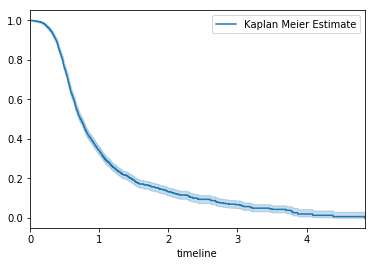

In [125]:
q = lum_250 - lum_rad
q_lim = lum_250_lim - lum_rad
const = np.max(q)
q = const - q
q_lim = const - q_lim

data = q
data[flag_250] = q_lim[flag_250]
det = (~flag_250).astype('int')
print('measured median from the detections is: {}'.format(const - np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(const - kmf.median_))
kmf.plot()
plt.show()

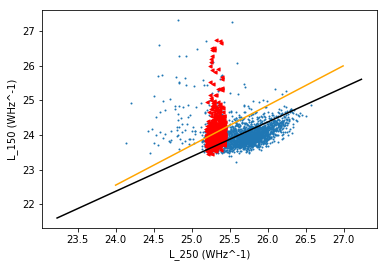

In [126]:
y = lum_rad[~flag_250]
x = lum_250[~flag_250]
plt.scatter(x,y,s=1)

x = lum_250_lim[flag_250]
y = lum_rad[flag_250]
plt.scatter(x,y,s=10,c='red',marker='<')

x = np.arange(np.min(lum_rad),np.max(lum_rad),0.1)
y = x-(const - kmf.median_)
plt.plot(x,y,c='black')

x = np.arange(24,27,0.01)
y = np.log10(gurkan_fit(10**x))
plt.plot(x,y,c='orange')


#plt.xlim(18,25)
#plt.ylim(19,26)
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

## Calculate median Q using survival analysis when removing AGN found suing CIGALE

In [76]:
np.sum(det)

1990

number of sources removed due to AGN cuts is: 11
measured median from the detections for SF is: 1.6536188070146025


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


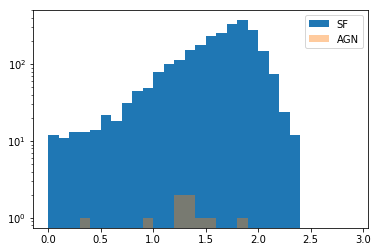

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median from the detections for AGN is: 1.2869491004516291
measured median using survival analysis is for SF: 1.632517501211563
measured median using survival analysis is for AGN: 1.2292462751519402


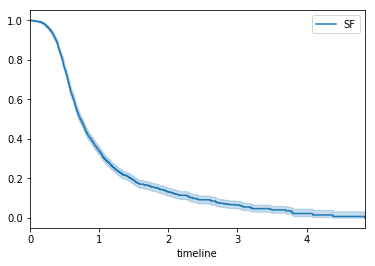

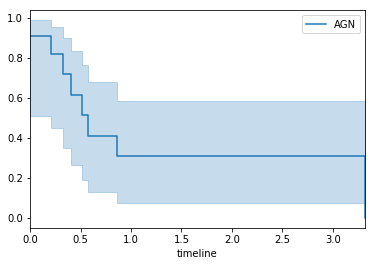

In [83]:
agn_flag = (lofar_cigale['bayes.agn.fracAGN']+lofar_cigale['bayes.agn.fracAGN_err']<0.4) 
mask = (~np.isnan(lofar_cigale['spire_250']))
agn_flag = agn_flag[mask]
print('number of sources removed due to AGN cuts is: {}'.format(np.sum(~agn_flag)))
q = lum_250[agn_flag] - lum_rad[agn_flag]
q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
const_sf = np.max(q)
bins = np.arange(0,3,0.1)
plt.hist(q,bins=bins,log=True,label='SF')
q = const_sf - q
q_lim = const_sf - q_lim




data = q
data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
det = (~flag_250[agn_flag]).astype('int')
print('measured median from the detections for SF is: {}'.format(const_sf - np.median(data)))

q = lum_250[~agn_flag] - lum_rad[~agn_flag]
q_lim = lum_250_lim[~agn_flag] - lum_rad[~agn_flag]
const_agn = np.max(q)
bins = np.arange(0,3,0.1)
plt.hist(q,bins=bins,log=True,label='AGN',alpha=0.4)
q = const_agn - q
q_lim = const_agn - q_lim


plt.legend()
plt.show()

data_agn = q
data_agn[flag_250[~agn_flag]] = q_lim[flag_250[~agn_flag]]
det_agn = (~flag_250[~agn_flag]).astype('int')
print('measured median from the detections for AGN is: {}'.format(const_agn - np.median(data_agn)))


kmf_sf = KaplanMeierFitter()
kmf_agn = KaplanMeierFitter()

## Fit the data into the model
kmf_sf.fit(data, det,label='SF')
kmf_agn.fit(data_agn, det_agn,label='AGN')
print('measured median using survival analysis is for SF: {}'.format(const_sf - kmf_sf.median_))
print('measured median using survival analysis is for AGN: {}'.format(const_agn - kmf_agn.median_))

## Create an estimate
kmf_sf.plot()
kmf_agn.plot()
plt.show()

In [54]:
const - kmf_sf.percentile(0.5)

1.594650952100661

In [96]:
thresholds = np.arange(0.01,0.4,0.01)
p_16_sf = []
p_50_sf = []
p_84_sf = []
p_16_agn = []
p_50_agn = []
p_84_agn = []
for threshold in thresholds:

    agn_flag = (lofar_cigale['bayes.agn.fracAGN']+lofar_cigale['bayes.agn.fracAGN_err']<threshold) 
    mask = (~np.isnan(lofar_cigale['spire_250']))
    agn_flag = agn_flag[mask]
    #print('number of sources removed due to AGN threshold of {} is: {}'.format(threshold,np.sum(~agn_flag)))
    q = lum_250[agn_flag] - lum_rad[agn_flag]
    q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
    const_sf = np.max(q)
    q = const_sf - q
    q_lim = const_sf - q_lim


    data = q
    data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
    det = (~flag_250[agn_flag]).astype('int')
    #print('measured median from the detections for SF is: {}'.format(const - np.median(data)))

    q = lum_250[~agn_flag] - lum_rad[~agn_flag]
    q_lim = lum_250_lim[~agn_flag] - lum_rad[~agn_flag]
    const_agn = np.max(q)
    q = const_agn - q
    q_lim = const_agn - q_lim
    data_agn = q
    data_agn[flag_250[~agn_flag]] = q_lim[flag_250[~agn_flag]]
    det_agn = (~flag_250[~agn_flag]).astype('int')
    #print('measured median from the detections for AGN is: {}'.format(const - np.median(data)))


    kmf_sf = KaplanMeierFitter()
    kmf_agn = KaplanMeierFitter()

    ## Fit the data into the model
    kmf_sf.fit(data, det,label='SF')
    kmf_agn.fit(data_agn, det_agn,label='AGN')
    #print('measured median using survival analysis is for threshold of {} for SF: {}'.format(threshold,const_sf - kmf_sf.median_))
    #print('measured median using survival analysis is for threshold of {} for AGN: {}'.format(threshold,const_agn - kmf_agn.median_))
    p_16_sf.append(const_sf - kmf_sf.percentile(0.16))
    p_50_sf.append(const_sf - kmf_sf.percentile(0.5))
    p_84_sf.append(const_sf - kmf_sf.percentile(0.84))
    p_16_agn.append(const_agn - kmf_agn.percentile(0.16))
    p_50_agn.append(const_agn - kmf_agn.percentile(0.5))
    p_84_agn.append(const_agn - kmf_agn.percentile(0.84))
    


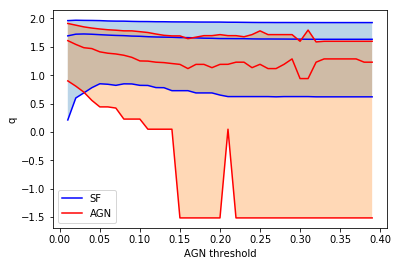

In [217]:
plt.plot(thresholds,p_50_sf,label='SF',c='blue')
plt.plot(thresholds,p_16_sf,c='blue')
plt.plot(thresholds,p_84_sf,c='blue')
plt.fill_between(thresholds,p_16_sf,p_84_sf,alpha=0.3)
plt.plot(thresholds,p_16_agn,label='AGN',c='red')
plt.plot(thresholds,p_50_agn,c='red')
plt.plot(thresholds,p_84_agn,c='red')
plt.fill_between(thresholds,p_16_agn,p_84_agn,alpha=0.3)
plt.xlabel('AGN threshold')
plt.ylabel('q')
plt.legend()
plt.show()

In [225]:
interest_agn[0]

<Row index=0 masked=True>
          id                   RA                DEC                 E_RA                  E_DEC               Total_flux           E_Total_flux           Peak_flux            E_Peak_flux       S_Code          Maj                   Min                  PA                 E_Maj                 E_Min                 E_PA               DC_Maj                DC_Min               DC_PA        FLAG_WORKFLOW Prefilter  NoID       lr_fin             optRA             optDec      LGZ_Size LGZ_Width  LGZ_PA Assoc Assoc_Qual Art_prob Blend_prob Hostbroken_prob Imagemissing_prob Zoom_prob        Created         Position_from Renamed_from FLAG_OVERLAP_RADIO flag_clean_radio  NUMBER  X_IMAGE  Y_IMAGE    ALPHA_J2000       DELTA_J2000    flag_clean NUMBER_OPTICAL NUMBER_SPITZER FLAG_OVERLAP Separation           help_id               RA_HELP          DEC_HELP         EBV      Z_SPEC  CLASS_STAR MegaCam.u.res MegaCam.u.res_err  PS1.g.res   PS1.g.res_err   PS1.r.res   PS1.r.res_err  PS1.i.res   PS1.i.res_err PS1.z.res  PS1.z.res_err  PS1.y.res  PS1.y.res_err HSC-g_mod.res HSC-g_mod.res_err HSC-r_mod.res HSC-r_mod.res_err HSC-i_mod.res HSC-i_mod.res_err HSC-z_mod.res HSC-z_mod.res_err HSC-Y_mod.res HSC-Y_mod.res_err wHSC-NB921_mod.res wHSC-NB921_mod.res_err UKIDSS.J.res UKIDSS.J.res_err UKIDSS.K.res UKIDSS.K.res_err IRAC.I1.res IRAC.I1.res_err IRAC.I2.res IRAC.I2.res_err ch1_swire_flux ch1_swire_fluxerr ch2_swire_flux ch2_swire_fluxerr IRAC.I3.res IRAC.I3.res_err IRAC.I4.res IRAC.I4.res_err  mips_24  FErr_MIPS_24_u FErr_MIPS_24_l Bkg_MIPS_24  Sig_conf_MIPS_24 Rhat_MIPS_24 n_eff_MIPS_24 Pval_res_24 flag_mips_24 pacs_green FErr_PACS_100_u FErr_PACS_100_l  pacs_red FErr_PACS_160_u FErr_PACS_160_l  Bkg_PACS_100  Bkg_PACS_160 Sig_conf_PACS_100 Sig_conf_PACS_160 Rhat_PACS_100 Rhat_PACS_160 n_eff_PACS_100 n_eff_PACS_160 Pval_res_100 Pval_res_160 flag_PACS_100 flag_PACS_160 spire_250 FErr_SPIRE_250_u FErr_SPIRE_250_l spire_350 FErr_SPIRE_350_u FErr_SPIRE_350_l spire_500 FErr_SPIRE_500_u FErr_SPIRE_500_l Bkg_SPIRE_250 Bkg_SPIRE_350 Bkg_SPIRE_500 Sig_conf_SPIRE_250 Sig_conf_SPIRE_350 Sig_conf_SPIRE_500 Rhat_SPIRE_250 Rhat_SPIRE_350 Rhat_SPIRE_500 n_eff_SPIRE_250 n_eff_SPIRE_500 n_eff_SPIRE_350 Pval_res_250 Pval_res_350 Pval_res_500 flag_spire_250 flag_spire_350 flag_spire_500  AGN   optAGN  IRAGN  XrayAGN redshift  z1_min  z1_max z1_area z2_median  z2_min  z2_max z2_area nfilt_eazy nfilt_atlas nfilt_ananna     chi_r_best       chi_r_stellar   stellar_type hp_idx_11 hp_depth_cluster     mips_24_err        pacs_green_err     pacs_red_err      spire_250_err    spire_350_err   spire_500_err    bayes.stellar.m_star bayes.stellar.m_star_err bayes.sfh.sfr10Myrs bayes.sfh.sfr10Myrs_err bayes.dust.luminosity bayes.dust.luminosity_err    bayes.dust.mass     bayes.dust.mass_err   bayes.dust.qpah   bayes.dust.qpah_err  bayes.dust.umin  bayes.dust.umin_err  bayes.agn.fracAGN  bayes.agn.fracAGN_err bayes.attenuation.Av_BC bayes.attenuation.Av_BC_err bayes.attenuation.bessell_b bayes.attenuation.bessell_b_err bayes.attenuation.galex_fuv bayes.attenuation.galex_fuv_err bayes.attenuation.slope_BC bayes.attenuation.slope_BC_err bayes.attenuation.BC_to_ISM_factor bayes.attenuation.BC_to_ISM_factor_err bayes.attenuation.slope_ISM bayes.attenuation.slope_ISM_err bayes.sfh.tau_main bayes.sfh.tau_main_err   bayes.sfh.age   bayes.sfh.age_err  bayes.sfh.burst_age bayes.sfh.burst_age_err  bayes.sfh.f_burst  bayes.sfh.f_burst_err  best.chi_square   best.reduced_chi_square best.agn.agn_luminosity best.agn.beta best.agn.fracAGN best.agn.gamma  best.agn.luminosity  best.agn.opening_angle best.agn.psy best.agn.r_ratio best.agn.scatt_luminosity best.agn.tau best.agn.therm_luminosity best.attenuation.Av_BC best.attenuation.BC_to_ISM_factor best.attenuation.bessell_b best.attenuation.galex_fuv best.attenuation.slope_BC best.attenuation.slope_ISM best.attenuation.stellar.old best.attenuation.stellar.young best.dust.alpha best.dust.gamma  best.dust.luminosity     be

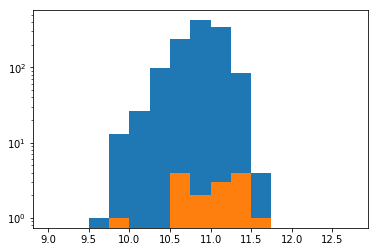

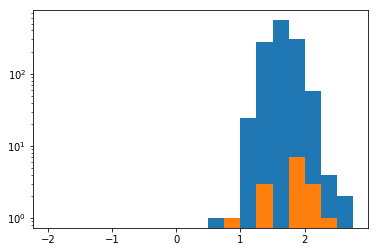

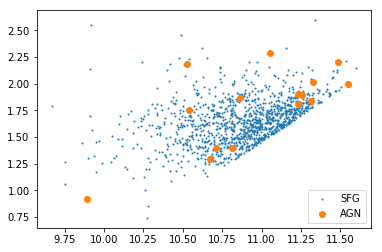

In [232]:
q = lum_250 - lum_rad
mask = ~np.isnan(lofar_cigale['spire_250'])
agn_flag = (lofar_cigale['bayes.agn.fracAGN'][mask]+lofar_cigale['bayes.agn.fracAGN_err'][mask]<0.3)
interest_agn = lofar_cigale[~np.isnan(lofar_cigale['spire_250'])][(q>1.0) & ~agn_flag]

agn_flag = (lofar_cigale['bayes.agn.fracAGN'][mask]+lofar_cigale['bayes.agn.fracAGN_err'][mask]<0.01)
ref_sfg = lofar_cigale[~np.isnan(lofar_cigale['spire_250'])][(q>1.5) & ~agn_flag]

bins = np.arange(9,13,0.25)
y = np.log10(ref_sfg['bayes.stellar.m_star'])
plt.hist(y,bins=bins,log=True)
y = np.log10(interest_agn['bayes.stellar.m_star'])
plt.hist(y,bins=bins,log=True)
plt.show()

bins = np.arange(-2,3,0.25)
y = np.log10(ref_sfg['bayes.sfh.sfr10Myrs'])
plt.hist(y,bins=bins,log=True)
y = np.log10(interest_agn['bayes.sfh.sfr10Myrs'])
plt.hist(y,bins=bins,log=True)
plt.show()

x = np.log10(ref_sfg['bayes.stellar.m_star'])
y = np.log10(ref_sfg['bayes.sfh.sfr10Myrs'])
plt.scatter(x,y,label='SFG',s=1)
x = np.log10(interest_agn['bayes.stellar.m_star'])
y = np.log10(interest_agn['bayes.sfh.sfr10Myrs'])
plt.scatter(x,y,label='AGN')
plt.legend()
plt.show()

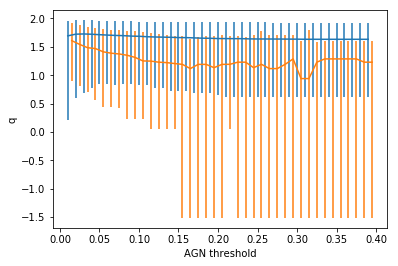

In [211]:
yerr_u = np.array(p_84_sf) - np.array(p_50_sf)
yerr_l = np.array(p_50_sf) - np.array(p_16_sf)
plt.errorbar(thresholds,p_50_sf,yerr=[yerr_l,yerr_u])
yerr_u = np.array(p_84_agn) - np.array(p_50_agn)
yerr_l = np.array(p_50_agn) - np.array(p_16_agn)
plt.errorbar(thresholds+0.005,p_50_agn,yerr=[yerr_l,yerr_u])
plt.xlabel('AGN threshold')
plt.ylabel('q')
plt.show()

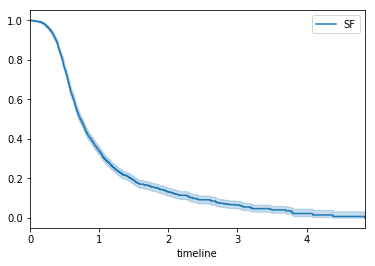

In [102]:
kmf_sf.plot()

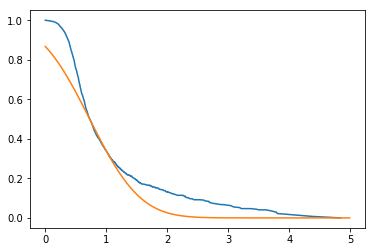

In [118]:
x = kmf_sf.timeline
y = 1-np.array(kmf_sf.cumulative_density_['SF'])
plt.plot(x,y)

mean = kmf_sf.percentile(0.5)
std = (kmf_sf.percentile(0.16) - kmf_sf.percentile(0.84))/2
x = np.arange(0,5,0.01)
y = gaus_cdf(x,[mean,std])
plt.plot(x,1-y)

In [121]:
y = 1-np.array(kmf_sf.cumulative_density_['SF'])
kstest(y,gaus_cdf,args=[[mean,std]])

KstestResult(statistic=0.33871910242419756, pvalue=2.3368030156067966e-271)

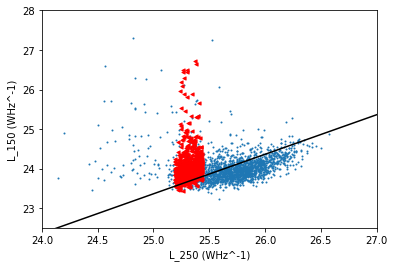

In [23]:
y = lum_rad[agn_flag & ~flag_250]
x = lum_250[agn_flag & ~flag_250]
plt.scatter(x,y,s=1)

x = lum_250_lim[agn_flag][flag_250[agn_flag]]
y = lum_rad[agn_flag][flag_250[agn_flag]]
plt.scatter(x,y,s=10,c='red',marker='<')

x = np.arange(17,28,1)
y = x-(const - kmf.median_)
plt.plot(x,y,c='black')


plt.xlim(24,27)
plt.ylim(22.5,28)
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

## Calculate median Q using survival analysis when removing AGN found using MIR colours

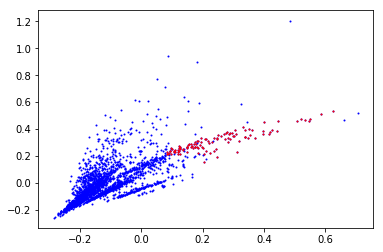

number of sources removed due to AGN cuts is: 107
measured median from the detections is: 1.6571818150390119
measured median using survival analysis is: 1.638674458220624


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


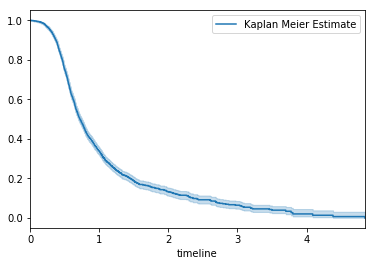

In [24]:
i1 = lofar_cigale['best.IRAC.I1.res']
i2 = lofar_cigale['best.IRAC.I2.res']
i3 = lofar_cigale['best.IRAC.I3.res']
i4 = lofar_cigale['best.IRAC.I4.res']
agn_flag = ~donley_agn(i1,i2,i3,i4,)
mask = (~np.isnan(lofar_cigale['spire_250']))
agn_flag = agn_flag[mask]
print('number of sources removed due to AGN cuts is: {}'.format(np.sum(~agn_flag)))
q = lum_250[agn_flag] - lum_rad[agn_flag]
q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
const = np.max(q)
q = const - q
q_lim = const - q_lim


data = q
data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
det = (~flag_250[agn_flag]).astype('int')
print('measured median from the detections is: {}'.format(const - np.median(data)))


kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')
print('measured median using survival analysis is: {}'.format(const - kmf.median_))

## Create an estimate
kmf.plot()
plt.show()